# Enviroment Setup

In [3]:
!pip install alpha_vantage


In [15]:
!pip install mplfinance pandas


In [16]:
import yfinance as yf
import pandas as pd
import requests
from datetime import datetime, timedelta
import re
from transformers import BertTokenizer, BertForSequenceClassification
import torch
import os
from alpha_vantage.timeseries import TimeSeries
import time
import mplfinance as mpf

# Data Collection

## Stock Data

### Alpha Vantage

#### Check Data

In [13]:
# Directory where stock data is stored
output_dir = "AAPL_30min_data"
os.makedirs(output_dir, exist_ok=True)

# List of years (2014-2024) and months
years = list(range(2014, 2025))
months_10yr = [f"{y}-{str(m).zfill(2)}" for y in years for m in range(1, 13)]

# List of NYSE stock market holidays (2014-2024)
stock_market_holidays = [
    "2024-01-01", "2024-01-15", "2024-02-19", "2024-03-29", "2024-05-27", "2024-06-19",
    "2024-07-04", "2024-09-02", "2024-11-28", "2024-12-25", "2023-01-02", "2023-01-16",
    "2023-02-20", "2023-04-07", "2023-05-29", "2023-07-04", "2023-09-04", "2023-11-23",
    "2023-12-25", "2022-01-01", "2022-01-17", "2022-02-21", "2022-04-15", "2022-05-30", 
    "2022-07-04", "2022-09-05", "2022-11-24", "2022-12-26", "2021-01-01", "2021-01-18",
    "2021-02-15", "2021-04-02", "2021-05-31", "2021-07-05", "2021-09-06", "2021-11-25", 
    "2021-12-24", "2020-01-01", "2020-01-20", "2020-02-17", "2020-04-10", "2020-05-25", 
    "2020-07-03", "2020-09-07", "2020-11-26", "2020-12-25", "2019-01-01", "2019-01-21", 
    "2019-02-18", "2019-04-19", "2019-05-27", "2019-07-04", "2019-09-02", "2019-11-28", 
    "2019-12-25", "2018-01-01", "2018-01-15", "2018-02-19", "2018-03-30", "2018-05-28", 
    "2018-07-04", "2018-09-03", "2018-11-22", "2018-12-25", "2017-01-02", "2017-01-16", 
    "2017-02-20", "2017-04-14", "2017-05-29", "2017-07-04", "2017-09-04", "2017-11-23", 
    "2017-12-25", "2016-01-01", "2016-01-18", "2016-02-15", "2016-03-25", "2016-05-30", 
    "2016-07-04", "2016-09-05", "2016-11-24", "2016-12-26", "2015-01-01", "2015-01-19", 
    "2015-02-16", "2015-04-03", "2015-05-25", "2015-07-03", "2015-09-07", "2015-11-26", 
    "2015-12-25", "2014-01-01", "2014-01-20", "2014-02-17", "2014-04-18", "2014-05-26", 
    "2014-07-04", "2014-09-01", "2014-11-27", "2014-12-25"
]
stock_market_holidays = [pd.to_datetime(date).date() for date in stock_market_holidays]

# Function to check if a month's data is complete
def check_existing_data(month):
    file_path = os.path.join(output_dir, f"AAPL_30min_{month}.csv")

    if os.path.exists(file_path):
        df = pd.read_csv(file_path, parse_dates=["date"], index_col="date")

        # Generate expected business days (Mon-Fri)
        expected_days = pd.date_range(start=f"{month}-01", end=f"{month}-28", freq="B")

        # Find missing weekdays (excluding stock market holidays)
        missing_days = [d.date() for d in expected_days if d.date() not in df.index.date and d.date() not in stock_market_holidays]

        if missing_days:
            print(f"⚠️ WARNING: {month} is missing these weekdays: {missing_days}")
            return False  # Data is incomplete
        else:
            print(f"✅ {month} data is already complete.")
            return True  # Data is complete

    else:
        print(f"❌ {month} data is missing.")
        return False  # File doesn't exist

# Check all months
months_to_fetch = [month for month in months_10yr if not check_existing_data(month)]

# Save missing months to a file (for later collection)
missing_months_file = os.path.join(output_dir, "missing_months_10yr.txt")
with open(missing_months_file, "w") as f:
    for month in months_to_fetch:
        f.write(month + "\n")

print("\n📊 Months that need to be fetched:", months_to_fetch)
print(f"📝 Missing months list saved in {missing_months_file}")


✅ 2014-01 data is already complete.
✅ 2014-02 data is already complete.
✅ 2014-03 data is already complete.
✅ 2014-04 data is already complete.
✅ 2014-05 data is already complete.
✅ 2014-06 data is already complete.
✅ 2014-07 data is already complete.
✅ 2014-08 data is already complete.
✅ 2014-09 data is already complete.
✅ 2014-10 data is already complete.
✅ 2014-11 data is already complete.
✅ 2014-12 data is already complete.
✅ 2015-01 data is already complete.
✅ 2015-02 data is already complete.
❌ 2015-03 data is missing.
❌ 2015-04 data is missing.
❌ 2015-05 data is missing.
❌ 2015-06 data is missing.
❌ 2015-07 data is missing.
❌ 2015-08 data is missing.
❌ 2015-09 data is missing.
❌ 2015-10 data is missing.
❌ 2015-11 data is missing.
❌ 2015-12 data is missing.
❌ 2016-01 data is missing.
❌ 2016-02 data is missing.
❌ 2016-03 data is missing.
❌ 2016-04 data is missing.
❌ 2016-05 data is missing.
❌ 2016-06 data is missing.
❌ 2016-07 data is missing.
❌ 2016-08 data is missing.
❌ 2016-09 

In [9]:
# Directory where stock data is stored
output_dir = "AAPL_30min_data"
os.makedirs(output_dir, exist_ok=True)

# List of months in 2024
months_2024 = [f"2024-{str(m).zfill(2)}" for m in range(1, 13)]

# List of 2024 U.S. stock market holidays
stock_market_holidays = [
    "2024-01-01", "2024-01-15", "2024-02-19", "2024-05-27", "2024-06-19",
    "2024-07-04", "2024-09-02", "2024-11-28", "2024-12-25"
]
stock_market_holidays = [pd.to_datetime(date).date() for date in stock_market_holidays]

# Function to check if a month's data is complete
def check_existing_data(month):
    file_path = os.path.join(output_dir, f"AAPL_30min_{month}.csv")

    if os.path.exists(file_path):
        df = pd.read_csv(file_path, parse_dates=["date"], index_col="date")

        # Generate expected business days (Mon-Fri)
        expected_days = pd.date_range(start=f"{month}-01", end=f"{month}-28", freq="B")

        # Find missing weekdays, excluding stock market holidays
        missing_days = [d.date() for d in expected_days if d.date() not in df.index.date and d.date() not in stock_market_holidays]

        if missing_days:
            print(f"⚠️ WARNING: {month} is missing these weekdays: {missing_days}")
            return False  # Data is incomplete
        else:
            print(f"✅ {month} data is already complete.")
            return True  # Data is complete

    else:
        print(f"❌ {month} data is missing.")
        return False  # File doesn't exist

# Check all months
months_to_fetch = [month for month in months_2024 if not check_existing_data(month)]

# Save missing months to a file (for later collection)
missing_months_file = os.path.join(output_dir, "missing_months.txt")
with open(missing_months_file, "w") as f:
    for month in months_to_fetch:
        f.write(month + "\n")

print("\n📊 Months that need to be fetched:", months_to_fetch)
print(f"📝 Missing months list saved in {missing_months_file}")


✅ 2024-01 data is already complete.
✅ 2024-02 data is already complete.
✅ 2024-03 data is already complete.
✅ 2024-04 data is already complete.
✅ 2024-05 data is already complete.
✅ 2024-06 data is already complete.
✅ 2024-07 data is already complete.
✅ 2024-08 data is already complete.
✅ 2024-09 data is already complete.
✅ 2024-10 data is already complete.
✅ 2024-11 data is already complete.
✅ 2024-12 data is already complete.

📊 Months that need to be fetched: []
📝 Missing months list saved in AAPL_30min_data\missing_months.txt


In [ ]:
# Api Key
api = X29K76EJP70V2JGP

#### Collect Data

In [11]:
# Your Alpha Vantage API Key
api_key = "X29K76EJP70V2JGP"

# Initialize Alpha Vantage API
ts = TimeSeries(key=api_key, output_format="pandas")

# Read the missing months file
missing_months_file = "AAPL_30min_data/missing_months_10yr.txt"

try:
    with open(missing_months_file, "r") as f:
        months_to_fetch = f.read().splitlines()
except FileNotFoundError:
    print("✅ No missing months found. Data is complete.")
    months_to_fetch = []

# Fetch data for each missing month
for month in months_to_fetch:
    output_file = f"AAPL_30min_data/AAPL_30min_{month}.csv"

    try:
        print(f"📊 Fetching data for {month}...")
        
        # Fetch data for the given month
        data, meta_data = ts.get_intraday(
            symbol="AAPL", 
            interval="30min", 
            month=month, 
            adjusted=True, 
            extended_hours=False,
            outputsize="full"
        )

        # Convert index to datetime
        data.index = pd.to_datetime(data.index)

        # Rename columns
        data.columns = ["Open", "High", "Low", "Close", "Volume"]

        # Save to CSV
        data.to_csv(output_file)
        
        print(f"✅ Successfully collected data for {month}")
        time.sleep(12)  # Avoid API rate limits

    except Exception as e:
        print(f"❌ Error fetching data for {month}: {e}")
        print("⚠️ Stopping process. Run the script again to continue from the last successful month.")
        break  # Stop execution if an error occurs

print("📊 All missing 30-minute interval stock data has been processed.")


📊 Fetching data for 2014-01...
✅ Successfully collected data for 2014-01
📊 Fetching data for 2014-02...
✅ Successfully collected data for 2014-02
📊 Fetching data for 2014-03...
✅ Successfully collected data for 2014-03
📊 Fetching data for 2014-04...
✅ Successfully collected data for 2014-04
📊 Fetching data for 2014-05...
✅ Successfully collected data for 2014-05
📊 Fetching data for 2014-06...
✅ Successfully collected data for 2014-06
📊 Fetching data for 2014-07...
✅ Successfully collected data for 2014-07
📊 Fetching data for 2014-08...
✅ Successfully collected data for 2014-08
📊 Fetching data for 2014-09...
✅ Successfully collected data for 2014-09
📊 Fetching data for 2014-10...
✅ Successfully collected data for 2014-10
📊 Fetching data for 2014-11...
✅ Successfully collected data for 2014-11
📊 Fetching data for 2014-12...
✅ Successfully collected data for 2014-12
📊 Fetching data for 2015-01...
✅ Successfully collected data for 2015-01
📊 Fetching data for 2015-02...
✅ Successfully colle

In [7]:
# Your Alpha Vantage API Key
api_key = "X29K76EJP70V2JGP"

# Initialize Alpha Vantage API
ts = TimeSeries(key=api_key, output_format="pandas")

# Read the missing months file
missing_months_file = "AAPL_30min_data/missing_months.txt"

try:
    with open(missing_months_file, "r") as f:
        months_to_fetch = f.read().splitlines()
except FileNotFoundError:
    print("✅ No missing months found. Data is complete.")
    months_to_fetch = []

# Function to fetch data for each missing month
for month in months_to_fetch:
    output_file = f"AAPL_30min_data/AAPL_30min_{month}.csv"

    try:
        print(f"📊 Fetching data for {month}...")
        data, meta_data = ts.get_intraday(symbol="AAPL", interval="30min", month=month, adjusted=True, extended_hours=False, outputsize="full")

        # Convert index to datetime
        data.index = pd.to_datetime(data.index)

        # Rename columns
        data.columns = ["Open", "High", "Low", "Close", "Volume"]

        # Save to CSV
        data.to_csv(output_file)
        
        print(f"✅ Successfully collected data for {month}")
        time.sleep(12)  # Avoid API rate limits

    except Exception as e:
        print(f"❌ Error fetching data for {month}: {e}")
        print("⚠️ Stopping process. Run the script again to continue from the last successful month.")
        break  # Stop execution if an error occurs

print("📊 All missing 30-minute interval stock data has been processed.")


📊 Fetching data for 2024-01...
✅ Successfully collected data for 2024-01
📊 Fetching data for 2024-02...
✅ Successfully collected data for 2024-02
📊 Fetching data for 2024-03...
✅ Successfully collected data for 2024-03
📊 Fetching data for 2024-04...
✅ Successfully collected data for 2024-04
📊 Fetching data for 2024-05...
✅ Successfully collected data for 2024-05
📊 Fetching data for 2024-06...
✅ Successfully collected data for 2024-06
📊 Fetching data for 2024-07...
✅ Successfully collected data for 2024-07
📊 Fetching data for 2024-08...
✅ Successfully collected data for 2024-08
📊 Fetching data for 2024-09...
✅ Successfully collected data for 2024-09
📊 Fetching data for 2024-10...
✅ Successfully collected data for 2024-10
📊 Fetching data for 2024-11...
✅ Successfully collected data for 2024-11
📊 Fetching data for 2024-12...
✅ Successfully collected data for 2024-12
📊 All missing 30-minute interval stock data has been processed.


#### Merge File

In [14]:
# Directory where monthly data is stored
data_dir = "AAPL_30min_data"

# List all CSV files
csv_files = [f for f in os.listdir(data_dir) if f.endswith(".csv") and "AAPL_30min_" in f]

# Create an empty DataFrame to store merged data
merged_df = pd.DataFrame()

# Load and append each file
for file in csv_files:
    file_path = os.path.join(data_dir, file)
    df = pd.read_csv(file_path, parse_dates=["date"], index_col="date")
    merged_df = pd.concat([merged_df, df])

# Sort by date
merged_df.sort_index(inplace=True)

# Save the merged dataset
output_file = "AAPL.csv"
merged_df.to_csv(output_file)

print(f"✅ Merged AAPL 30-minute data (2014-2024) saved as {output_file}")
print(merged_df.head())  # Display first few rows


✅ Merged AAPL 30-minute data (2014-2024) saved as AAPL.csv
                        Open     High      Low    Close    Volume
date                                                             
2014-01-02 04:00:00  17.2266  17.3138  17.2266  17.3057  135072.0
2014-01-02 04:30:00  17.3044  17.3047  17.3001  17.3001   16800.0
2014-01-02 05:00:00  17.2823  17.2823  17.2581  17.2581    8400.0
2014-01-02 05:30:00  17.2562  17.2649  17.2562  17.2649   14000.0
2014-01-02 06:00:00  17.3075  17.3107  17.2733  17.2733   59584.0


### yfinance

#### Collect Data

In [2]:
# Define your tech stocks list
tech_stocks = ["AAPL", "MSFT", "NVDA", "AMZN", "GOOGL", "META", "TSLA", "AMD", "NFLX", "AVGO"]

# Function to fetch historical stock data
def fetch_stock_data(stocks, period="1y"):
    stock_data = {}
    for stock in stocks:
        df = yf.download(stock, period=period, interval="1d")  # Daily data
        stock_data[stock] = df
        print(f"Downloaded {stock} data.")
    return stock_data

# Fetch stock data
stock_data = fetch_stock_data(tech_stocks)

# Save each stock's data as CSV
for stock, df in stock_data.items():
    df.to_csv(f"{stock}_historical_data.csv")

print("Stock data collection complete and saved to CSV files.")


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Downloaded AAPL data.
Downloaded MSFT data.


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Downloaded NVDA data.
Downloaded AMZN data.
Downloaded GOOGL data.


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Downloaded META data.
Downloaded TSLA data.
Downloaded AMD data.



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Downloaded NFLX data.
Downloaded AVGO data.
Stock data collection complete and saved to CSV files.


#### Check Missing Value

In [3]:
df = pd.read_csv("AAPL_historical_data.csv")  # Replace with any stock CSV file
print(df.info())  # Check data types and missing values
print(df.head())  # Preview first few rows


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252 entries, 0 to 251
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Price   252 non-null    object
 1   Close   251 non-null    object
 2   High    251 non-null    object
 3   Low     251 non-null    object
 4   Open    251 non-null    object
 5   Volume  251 non-null    object
dtypes: object(6)
memory usage: 11.9+ KB
None
        Price               Close                High                 Low  \
0      Ticker                AAPL                AAPL                AAPL   
1        Date                 NaN                 NaN                 NaN   
2  2024-02-20   180.7067108154297  181.57261717237213   179.1540448566047   
3  2024-02-21   181.4631805419922  182.03049388623003  179.81097819372195   
4  2024-02-22  183.50350952148438  184.09074823448796  181.60249751065342   

                 Open    Volume  
0                AAPL      AAPL  
1                 NaN       NaN

## News Data

In [5]:
# Your NewsAPI Key
api_key = "31dbe344e851496e950dc899ab1d0e93"

# List of tech stocks to search for
tech_stocks = ["Apple", "Microsoft", "Nvidia", "Amazon", "Google", "Meta", "Tesla", "AMD", "Netflix", "Broadcom"]

# Date range for news (last 7 days)
end_date = datetime.today().strftime('%Y-%m-%d')
start_date = (datetime.today() - timedelta(days=7)).strftime('%Y-%m-%d')

# Function to fetch news for each stock
def fetch_news(stock):
    url = f"https://newsapi.org/v2/everything?q={stock}&language=en&from={start_date}&to={end_date}&sortBy=publishedAt&apiKey={api_key}"
    response = requests.get(url)
    return response.json()

# Collect news for all stocks
news_data = []
for stock in tech_stocks:
    data = fetch_news(stock)
    if "articles" in data:
        for article in data["articles"]:
            news_data.append({
                "Stock": stock,
                "Title": article["title"],
                "Source": article["source"]["name"],
                "Published At": article["publishedAt"],
                "URL": article["url"]
            })

# Convert to DataFrame
df_news = pd.DataFrame(news_data)

# Save to CSV
df_news.to_csv("tech_stock_news.csv", index=False)

print("News data collected and saved to 'tech_stock_news.csv'.")


News data collected and saved to 'tech_stock_news.csv'.


In [6]:
# Load the collected news data
df_news = pd.read_csv("tech_stock_news.csv")

# Display first few rows
print(df_news.head())


   Stock                                              Title          Source  \
0  Apple  Tudor Financial Inc. Grows Stock Holdings in A...  ETF Daily News   
1  Apple  iPhone SE 4 live: latest news and rumors ahead...    Slashdot.org   
2  Apple  Apple’s February 2025 Event. 6 Biggest Predict...   Geeky Gadgets   
3  Apple             How Eric Adams Got His Charges Dropped  Slate Magazine   
4  Apple  Apple’s political turn is leading it down a sk...        Macworld   

           Published At                                                URL  
0  2025-02-18T10:32:53Z  https://www.etfdailynews.com/2025/02/18/tudor-...  
1  2025-02-18T10:32:40Z  https://slashdot.org/firehose.pl?op=view&amp;i...  
2  2025-02-18T10:30:56Z  https://www.geeky-gadgets.com/apples-february-...  
3  2025-02-18T10:30:00Z  https://slate.com/podcasts/what-next/2025/02/w...  
4  2025-02-18T10:30:00Z  https://www.macworld.com/article/2611168/apple...  


In [7]:
def clean_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'\s+', ' ', text)  # Remove extra spaces
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = text.strip()  # Remove leading/trailing spaces
    return text

# Apply cleaning
df_news["Cleaned_Title"] = df_news["Title"].apply(clean_text)

# Save cleaned data
df_news.to_csv("cleaned_tech_stock_news.csv", index=False)

print("Data cleaned and saved.")


Data cleaned and saved.


# Sentiment Analysis

## FinBERT model

In [1]:
# Load FinBERT tokenizer & model
tokenizer = BertTokenizer.from_pretrained("yiyanghkust/finbert-tone")
model = BertForSequenceClassification.from_pretrained("yiyanghkust/finbert-tone")


In [2]:
import torch.nn.functional as F

def predict_sentiment(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)
    outputs = model(**inputs)
    probs = F.softmax(outputs.logits, dim=-1)

    # Labels: 0 = Negative, 1 = Neutral, 2 = Positive
    labels = ["Negative", "Neutral", "Positive"]
    sentiment = labels[torch.argmax(probs).item()]
    
    return sentiment

# Test on an example headline
example_headline = "Apple stock soars as earnings beat expectations"
print(f"Sentiment: {predict_sentiment(example_headline)}")


Sentiment: Neutral


In [5]:
df_news = pd.read_csv("cleaned_tech_stock_news.csv")

# Apply sentiment analysis to each headline
df_news["Sentiment"] = df_news["Cleaned_Title"].apply(predict_sentiment)

# Save results
df_news.to_csv("news_sentiment_analysis.csv", index=False)

print("Sentiment analysis complete. Results saved.")


Sentiment analysis complete. Results saved.


In [6]:
# Load the dataset with sentiment analysis results
df_news = pd.read_csv("news_sentiment_analysis.csv")

# Count the occurrences of each sentiment category
sentiment_counts = df_news["Sentiment"].value_counts()

# Display results
print(sentiment_counts)


Sentiment
Negative    773
Positive    105
Neutral      91
Name: count, dtype: int64


# Chart Analysis

C:\anaconda\envs\FYP\Lib\site-packages\mplfinance\_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


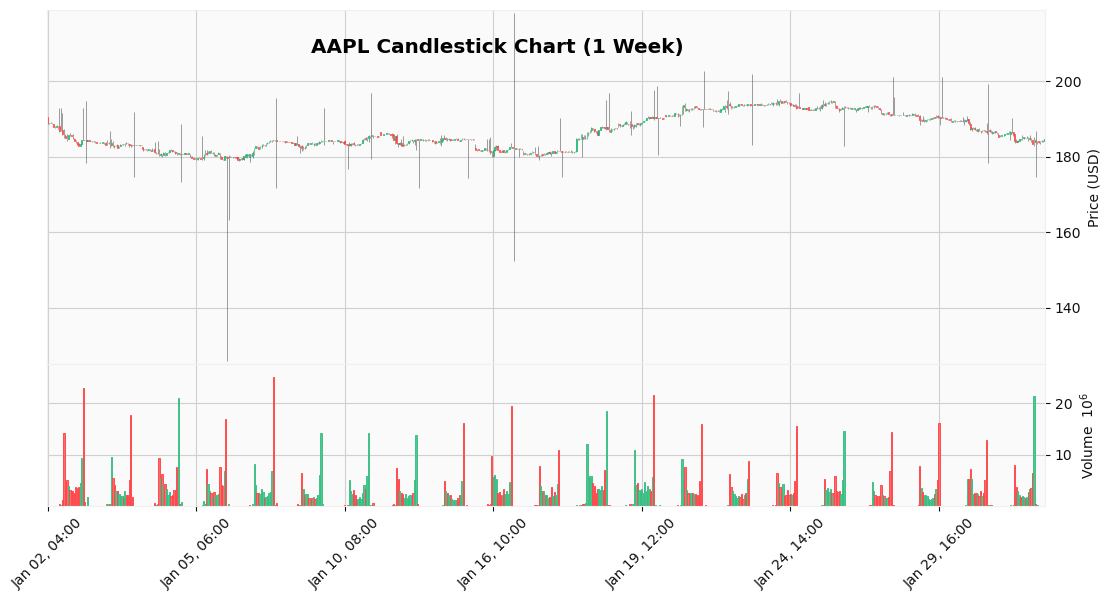

In [20]:
# Load collected AAPL data
df = pd.read_csv("AAPL.csv", parse_dates=["date"], index_col="date")

# Select a specific period to visualize (e.g., 1 week in 2024)
df_sample = df.loc["2024-01-02":"2024-01-31"]  # Change dates as needed

# Ensure the DataFrame has the correct columns
df_sample = df_sample[["Open", "High", "Low", "Close", "Volume"]]

# Plot candlestick chart
mpf.plot(
    df_sample,
    type="candle",
    style="yahoo",
    title="AAPL Candlestick Chart (1 Week)",
    ylabel="Price (USD)",
    volume=True,
    figratio=(12,6),  # Adjust figure size
    #mav=(5, 10),  # Add moving averages (5-day & 10-day)
    tight_layout=True
)
